In [1]:
import sys

sys.path.append("../")  # up one level

import os
import shutil

import gcsfs
import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
from calitp_data_analysis.tables import tbls
from segment_speed_utils.project_vars import PUBLIC_GCS
from siuba import _, collect, count, filter, select, show_query
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Work plan

## Need List of all annual reporters
- Full, Reduced, Rural reporters all submit an annual Report to NTD

## Need to assign rural and reduced annual reporters to RTPAs
- Full reporters are already mapped to RTPAs via the monthly report
- but reduced and rurap reporters need to be mapped to RTPAs

### How to traverse operators to RTPA?
- find all the operators in a GTFS schedule. 
- do any of the rural operators appear in a schedule?
    - if so, then what is the RTPA of that schedule!!!!!
    - ntd > operator > schedule > RTPA 

## Read in `dim_annual_service_agencies` to get metrics
but need to RTPA info to this data

In [2]:
# dim_annual_service_agenices is the annual report module.
# included uza, VRM, VRH, UPT
# report years include 2022-2023

ntd_service = (
    tbls.mart_ntd.dim_annual_service_agencies()
    >> filter(_.state == "CA")
    >> select(
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "organization_type",
        "city",
        "state",
        "primary_uza_name",
        "actual_vehicles_passenger_car_revenue_hours",
        "actual_vehicles_passenger_car_revenue_miles",
        "unlinked_passenger_trips_upt",
    )
    >> collect()
)
ntd_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         418 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

In [3]:
list(ntd_service.columns)

['report_year',
 'ntd_id',
 'agency',
 'reporter_type',
 'organization_type',
 'city',
 'state',
 'primary_uza_name',
 'actual_vehicles_passenger_car_revenue_hours',
 'actual_vehicles_passenger_car_revenue_miles',
 'unlinked_passenger_trips_upt']

### update `ntd_service` to:
- 90227 City of Moorpark > city = Moorpark
- 90253 City of Bell Gardens > city = Bell Gardens
- 90259 City of Cerritos > city = Cerritos
- 90286 City of Monterey Park > city = Monterey Park

In [4]:
#Moorpark Update
ntd_service.loc[ntd_service["ntd_id"]=="90227","city"] = "Moorpark"

# Bell Gardens Update
ntd_service.loc[ntd_service["ntd_id"]=="90253","city"] = "Bell Gardens"

# Cerritos Update
ntd_service.loc[ntd_service["ntd_id"]=="90259","city"] = "Cerritos"

# Monterey Park Update
ntd_service.loc[ntd_service["ntd_id"]=="90286","city"] = "Monterey Park"

### Does `ntd_id-to-rtap crosswalk` include rural/reduced reporter info?

In [5]:
# reading in NTD ID crosswalk from GCS
ntd_rtpa_crosswalk = pd.read_csv(
    f"{GCS_FILE_PATH}ntd_id_rtpa_crosswalk.csv", dtype={"ntd_id": "str"}
).rename(columns={"NTD ID": "ntd_id"})

ntd_rtpa_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ntd_id          122 non-null    object
 1   Legacy NTD ID   111 non-null    object
 2   Agency          122 non-null    object
 3   UZA Name        121 non-null    object
 4   RTPA_open_data  122 non-null    object
 5   RTPA            122 non-null    object
dtypes: object(6)
memory usage: 5.8+ KB


In [6]:
# are all agencies in the ntd_service in the crosswalk? NO
check = ntd_service.merge(ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True)

# the rural reporters are not in the ntd_rtpa_crosswalk
check[check["_merge"] == "left_only"]["reporter_type"].value_counts()

Reduced Reporter    132
Rural Reporter       89
Name: reporter_type, dtype: int64

In [7]:
# crosswalk[["UZA Name", "RTPA"]].sort_values(by="UZA Name")

Some UZA Names can go to multiple RTPAs
- some agencies in the Sacramento UZA go to Sac and Placer RTPA
- some agencies in LA UZA got to Metro or OCTA


In [8]:
# just rural/reduced reporters
rural_reduced_reporters = ntd_service[
    ntd_service["reporter_type"] != "Full Reporter"
].sort_values(by="primary_uza_name")

In [9]:
# rural_reduced_reporters.to_csv("rural_reduced_reporters.csv")

## Get all operators from RTPA using function from Tiffany

via [slack thread](https://cal-itp.slack.com/archives/C02H6JUSS9L/p1729102048291249)

initial work done in `rtpa_operator_explore.ipynb`

- rip `create_gtfs_dataset_key_to_organization_crosswalk` function from `gtfs_funnel/crosswalk_gtfs_dataset_key_to_organization.py`
- rip any date from GCS (latest is 2025-01-15) `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`
- find the corresponding `gtfs_key-to-org crosswalk` by date (2025-01-15) via `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`

can use these 2 dataframes to go from `schedule_gtfs_dataset_key (operator)` > `ntd_id`

A single schedule feed can have multiple operators. This is how you identify 

In [10]:
# need this to run `create_gtfs_dataset_key_to_organzaition_crosswalk`
from segment_speed_utils import helpers
from shared_utils.schedule_rt_utils import (
    sample_gtfs_dataset_key_to_organization_crosswalk,
)

In [11]:
def create_gtfs_dataset_key_to_organization_crosswalk(
    analysis_date: str,
) -> pd.DataFrame:
    """
    For every operator that appears in schedule data,
    create a crosswalk that links to organization_source_record_id.
    For all our downstream outputs, at various aggregations,
    we need to attach these over and over again.
    """
    df = helpers.import_scheduled_trips(
        analysis_date, columns=["gtfs_dataset_key", "name"], get_pandas=True
    ).rename(columns={"schedule_gtfs_dataset_key": "gtfs_dataset_key"})
    # rename columns because we must use simply gtfs_dataset_key in schedule_rt_utils function

    # Get base64_url, organization_source_record_id and organization_name
    crosswalk = sample_gtfs_dataset_key_to_organization_crosswalk(
        df,
        analysis_date,
        quartet_data="schedule",
        dim_gtfs_dataset_cols=["key", "source_record_id", "base64_url"],
        dim_organization_cols=[
            "source_record_id",
            "name",
            "itp_id",
            "caltrans_district",
            "ntd_id_2022",
        ],
    )

    df_with_org = pd.merge(
        df.rename(columns={"gtfs_dataset_key": "schedule_gtfs_dataset_key"}),
        crosswalk,
        on="schedule_gtfs_dataset_key",
        how="inner",
    )

    return df_with_org

In [12]:
# get gtfs to org df,
# same date as used below
gtfs_to_org = create_gtfs_dataset_key_to_organization_crosswalk(
    "2025-01-15"  # 216 total rows
    # "2024-10-14" #209 rows
    # "2024-08-14" #206 rows
    # "2024-03-13" #193 rows
).rename(columns={"name": "schedule_name"})


gtfs_to_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   schedule_gtfs_dataset_key      216 non-null    object 
 1   schedule_name                  216 non-null    object 
 2   schedule_source_record_id      216 non-null    object 
 3   base64_url                     216 non-null    object 
 4   organization_source_record_id  216 non-null    object 
 5   organization_name              216 non-null    object 
 6   itp_id                         204 non-null    float64
 7   caltrans_district_x            214 non-null    object 
 8   ntd_id_2022                    172 non-null    object 
 9   caltrans_district_y            216 non-null    object 
dtypes: float64(1), object(9)
memory usage: 18.6+ KB


In [13]:
# initialize gtfs rosswalk
gtfs_key_orgs = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2025-01-15.parquet"
)
gtfs_key_orgs.columns # not sure i cant use these columns

Index(['schedule_gtfs_dataset_key', 'name', 'schedule_source_record_id',
       'base64_url', 'organization_source_record_id', 'organization_name',
       'caltrans_district', 'counties_served', 'hq_city', 'hq_county',
       'is_public_entity', 'is_publicly_operating', 'funding_sources',
       'on_demand_vehicles_at_max_service', 'vehicles_at_max_service',
       'number_of_state_counties', 'primary_uza_name', 'density',
       'number_of_counties_with_service', 'state_admin_funds_expended',
       'service_area_sq_miles', 'population', 'service_area_pop',
       'subrecipient_type', 'primary_uza_code', 'reporter_type',
       'organization_type', 'voms_pt', 'voms_do', 'year'],
      dtype='object')

## Merge `ntd_service` data to `gtfs_to_orgs` list
Results should be the ntd_service data with the GTFS schedule name 

In [14]:
keep_cols = [
    "schedule_gtfs_dataset_key",
    "schedule_name",
    "organization_name",
    "ntd_id_2022",
]

ntd_metrics_to_sched = ntd_service.merge(
    gtfs_to_org[keep_cols],
    right_on="ntd_id_2022",
    left_on="ntd_id",
    how="left",
    indicator=True,
)
display(ntd_metrics_to_sched.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 454
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  455 non-null    int64   
 1   ntd_id                                       455 non-null    object  
 2   agency                                       455 non-null    object  
 3   reporter_type                                455 non-null    object  
 4   organization_type                            455 non-null    object  
 5   city                                         455 non-null    object  
 6   state                                        455 non-null    object  
 7   primary_uza_name                             356 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  455 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  455 non-null    floa

None

In [15]:
ntd_metrics_to_sched["_merge"].value_counts()
# so there are some left-only rows, meaning some operators did not match to schedule
# on date 2025-01-15: 257 both, 88 left_only = 88 reporters did not match to a shcedule

both          326
left_only     129
right_only      0
Name: _merge, dtype: int64

In [16]:
# what are the reporter types for these left_only operators?
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    "reporter_type"
].value_counts()  # 65 reduced, 23 full reporters

# also checked "both" and got mix of full, reduced and rural
# may need to check a different crosswalk data

Reduced Reporter    74
Rural Reporter      32
Full Reporter       23
Name: reporter_type, dtype: int64

In [17]:
# looking into the cities of the left_only merges
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    ["agency", "reporter_type", "city"]
].value_counts()

agency                                                                          reporter_type     city            
Los Angeles County                                                              Reduced Reporter  Alhambra            9
Access Services                                                                 Full Reporter     El Monte            2
City of Malibu                                                                  Reduced Reporter  Malibu              2
Paratransit, Inc.                                                               Full Reporter     Sacramento          2
City of Covina                                                                  Reduced Reporter  Covina              2
City of Davis, dba: Davis Community Transit                                     Reduced Reporter  Davis               2
Easy Lift Transportation                                                        Reduced Reporter  Goleta              2
City of Huntington Park                      

In [18]:
# if i sort by city, can i match copy the RTPA of the good rows to the left_only rows?
ntd_metrics_to_sched[
    ["agency", "city", "schedule_gtfs_dataset_key", "schedule_name", "_merge"]
].sort_values(by=["city", "agency"], ascending=True).head(10)

,agency,city,schedule_gtfs_dataset_key,schedule_name,_merge
334,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
335,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
337,"City of Alhambra, dba: Alhambra Community Transit",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
336,"City of Alhambra, dba: Alhambra Community Tran...",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
381,Los Angeles County,Alhambra,NaN,NaN,left_only
382,Los Angeles County,Alhambra,2606479845d2cf0077fac54ff25a3a69,LADPW Schedule,both
384,Los Angeles County,Alhambra,NaN,NaN,left_only
386,Los Angeles County,Alhambra,NaN,NaN,left_only
388,Los Angeles County,Alhambra,NaN,NaN,left_only
391,Los Angeles County,Alhambra,NaN,NaN,left_only


## merge `ntd_metrics_to_sched` df to `ntd_to_rtpa` crosswalk
Result should be a df of ntd service reports with GTFS schedule, then RTPA name merged in

In [19]:
metrics_sched_rtpa = ntd_metrics_to_sched.drop(columns="_merge", axis=1).merge(
    ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True
)

metrics_sched_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  457 non-null    int64   
 1   ntd_id                                       457 non-null    object  
 2   agency                                       457 non-null    object  
 3   reporter_type                                457 non-null    object  
 4   organization_type                            457 non-null    object  
 5   city                                         457 non-null    object  
 6   state                                        457 non-null    object  
 7   primary_uza_name                             358 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  457 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  457 non-null    floa

In [20]:
metrics_sched_rtpa["_merge"].value_counts()
# on date 2025-01-15: 227 both, 120 left_only = 120 reporters did not match to a RTPA
# ideally want every row to match

left_only     229
both          228
right_only      0
Name: _merge, dtype: int64

In [21]:
# get DF of agencies > reporter type > city > schedule name > rtpa
# if 2 reporters share the same City, then are they part of the same schedule? or part of the same RTPA?

metrics_sched_rtpa[
    [
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "city",
        "schedule_name",
        "RTPA",
    ]
].sort_values(by=["city", "RTPA"], ascending=True)

# examples to pull: Camarillo, Riverside, 

,report_year,ntd_id,agency,reporter_type,city,schedule_name,RTPA
336,2023,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
337,2022,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
338,2022,90247,"City of Alhambra, dba: Alhambra Community Tran...",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
339,2023,90247,"City of Alhambra, dba: Alhambra Community Transit",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
380,2023,90269,"Los Angeles County, dba: LA County Public Works",Reduced Reporter,Alhambra,NaN,NaN
381,2022,90269,Los Angeles County Dept. of Public Works - Ath...,Reduced Reporter,Alhambra,NaN,NaN
382,2022,90270,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,NaN,NaN
383,2023,90270,Los Angeles County,Reduced Reporter,Alhambra,NaN,NaN
384,2023,90271,Los Angeles County,Reduced Reporter,Alhambra,LADPW Schedule,NaN
385,2022,90271,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,LADPW Schedule,NaN


## try merging GDF of city in `ntd_service` to RTPA bounaries.
- To match agency cities to RTPAs. (this method doesnt need schedule info)

Census Designated Places (CDPs) 2010 - California map
- https://data.sacog.org/datasets/SACOG::census-designated-places-cdps-2010-california/about

~~California Incorporated Cities (dont think this included census derived places or unincorporated areas.)~~
~~- https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::california-incorporated-cities-1/explore~~

RTPA map opend data
- https://www.lab.data.ca.gov/dataset/regional-transportation-planning-agencies

In [22]:
import geopandas as gpd

In [23]:
rtpa_url = "https://cecgis-caenergy.opendata.arcgis.com/api/download/v1/items/3a83743378be4e7f84c8230889c01dea/geojson?layers=0"
rtpa_map = gpd.read_file(rtpa_url)[["RTPA","LABEL_RTPA","geometry"]]#.set_crs("ESRI:102600", allow_override=True)
print(rtpa_map.crs)
rtpa_map = rtpa_map.to_crs("ESRI:102600")
print(rtpa_map.crs)

EPSG:4326
ESRI:102600


In [24]:
# .explore() still works
rtpa_map.head().explore()

In [25]:
# California Incorporated Cities!!!!! dont think this included census derived places or unincorporated areas.
#cities_url="https://gis.data.cnra.ca.gov/api/download/v1/items/8322505e8f1741c7b0de85684594e32a/geojson?layers=0"
#cities_map =gpd.read_file(cities_url)[["COUNTY","CITY","geometry"]]#.set_crs("ESRI:102600", allow_override=True)

In [26]:
# California Census Designated Places (2010), includes cities and CDPs
# 

cdp_url="https://services6.arcgis.com/YBp5dUuxCMd8W1EI/arcgis/rest/services/California_Census_Designated_Places_2010/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
keep_cdp_col=["FID","NAME10","NAMELSAD10","geometry"]
cdp_map= gpd.read_file(cdp_url)#.set_crs("ESRI:102600", allow_override=True)

print(cdp_map.columns)

cdp_map= cdp_map[keep_cdp_col].rename(columns={"NAME10":"cdp_name","NAMELSAD10":"name_lsad"})

Index(['FID', 'STATEFP10', 'PLACEFP10', 'PLACENS10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'CLASSFP10', 'PCICBSA10', 'PCINECTA10',
       'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'Shape_STAr', 'Shape_STLe', 'geometry'],
      dtype='object')


### test getting centroid of CDPs

In [32]:
cdp_map["centroid"] = cdp_map["geometry"].to_crs("ESRI:102600").centroid # CRS used to create centoid. is not presistent
cdp_points= cdp_map.set_geometry("centroid", drop=True)

display(
cdp_map.info(),
cdp_points.info(), #geometry column here is point geometry 
cdp_map.crs,
    cdp_points.crs,
    cdp_points.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        1523 non-null   int64   
 1   cdp_name   1523 non-null   object  
 2   name_lsad  1523 non-null   object  
 3   geometry   1523 non-null   geometry
 4   centroid   1523 non-null   geometry
dtypes: geometry(2), int64(1), object(2)
memory usage: 59.6+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        1523 non-null   int64   
 1   cdp_name   1523 non-null   object  
 2   name_lsad  1523 non-null   object  
 3   geometry   1523 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 47.7+ KB


None

None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Projected CRS: ESRI:102600>
Name: NAD_1983_California_Teale_Albers_FtUS
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: NAD_1983_California_Teale_Albers_FtUS
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

,FID,cdp_name,name_lsad,geometry
0,1,Tehama,Tehama city,POINT (-595373.083 9861237.699)
1,2,Red Bluff,Red Bluff city,POINT (-626074.577 9917237.059)
2,3,Corning,Corning city,POINT (-611576.889 9827491.545)
3,4,Williams,Williams city,POINT (-605443.950 9543097.586)
4,5,Colusa,Colusa city,POINT (-568847.549 9562798.386)


In [28]:
display(
    cdp_points["cdp_name"].value_counts().head() # still see the same duplicate cdp (but are in different locations.)
    #cdp_map[cdp_map["cdp_name"]=="El Cerrito"]
)

Green Valley    2
Cold Springs    2
El Cerrito      2
Greenfield      2
Bear Valley     2
Name: cdp_name, dtype: int64

## sjoin ~~`cities_map`~~ `cdp_map` gdf and `rtpa_map` gdf to attach RTPA name to cities

In [34]:
cdp_points.crs == rtpa_map.crs
#both are ESRI:102600

True

In [50]:
city_to_rtpa = gpd.sjoin(
    #cities_map, #only incorporated cities, not CDP are commonly known areas. 510 rows with left join
    cdp_points, # includes cities and CDPs. 1606 rows with left join
    rtpa_map,
    how="left",
    #how="inner",
    predicate="intersects", # 1605 rows, but have some CDP that intersects the edges of 3 RTPAs (Folsom appears 3 times, get assigned 3 different RTPAs)
    #predicate="within", #1426 rows, only returns cities that are completely within an RTPA, drops cities that touch multiple rtap boundaries entirely (drops Folsom) 
    #census places within the RTPA boundaries. but some cdp span multiple RTPAs
)
# left, intersects = 1523 rows, 1521 CDPs matched,2 CDPs did not match to an RTPA (Avalon and City of San Francisco)
# inner, intersects = 1521 rows,1521 CDPs matched 
# left, within = 1523 rows, 1521 CDPs matched,2 CDPs did not match to an RTPA
# inner, within = 1521 rows,1521 CDPs matched

display(
    len(cdp_points),
    len(rtpa_map),
    city_to_rtpa[city_to_rtpa["RTPA"].isna()], # checking for unmerged cdps
    city_to_rtpa.info(),
    city_to_rtpa.crs

)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1523 entries, 0 to 1522
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          1523 non-null   int64   
 1   cdp_name     1523 non-null   object  
 2   name_lsad    1523 non-null   object  
 3   geometry     1523 non-null   geometry
 4   index_right  1521 non-null   float64 
 5   RTPA         1521 non-null   object  
 6   LABEL_RTPA   1521 non-null   object  
dtypes: float64(1), geometry(1), int64(1), object(4)
memory usage: 95.2+ KB


1523

43

,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
862,863,Avalon,Avalon city,POINT (510003.406 7421706.792),NaN,NaN,NaN
889,890,San Francisco,San Francisco city,POINT (-777550.185 9040909.841),NaN,NaN,NaN


None

<Projected CRS: ESRI:102600>
Name: NAD_1983_California_Teale_Albers_FtUS
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: NAD_1983_California_Teale_Albers_FtUS
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [48]:
# Why do these cdp occur twice?
check_names= [
"Burbank",
"Paradise",
"Strawberry",
"Live Oak",
"Rolling Hills",
"Spring Valley",
"Cold Springs",
"Greenfield",
"Green Valley",
"Mountain View",
"El Cerrito",
"Franklin",
"San Miguel",
"Las Flores",
"Bayview",
"El Sobrante"
]

city_to_rtpa[city_to_rtpa["cdp_name"].isin(check_names)].sort_values(by="cdp_name") 
# Some places in CA have the same name, but are in different locations! Burbank in NorCal and Burbank in SoCal!
# after reviewing all these, theres should not be an conflicts since all the RTPs are in different locations/not conflicting

,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
1384,1385,Bayview,Bayview CDP,POINT (-1157476.285 10150984.394),10,Humboldt County Association of Governments,Humboldt CAG
1041,1042,Bayview,Bayview CDP,POINT (-667585.382 9127613.797),20,Metropolitan Transportation Commission,MTC
852,853,Burbank,Burbank city,POINT (506926.263 7732433.446),35,Southern California Association of Governments,SCAG
240,241,Burbank,Burbank CDP,POINT (-560442.842 8875457.036),20,Metropolitan Transportation Commission,MTC
1327,1328,Cold Springs,Cold Springs CDP,POINT (-249560.830 9390874.336),7,El Dorado County Transportation Commission,El Dorado CTC
1157,1158,Cold Springs,Cold Springs CDP,POINT (-15371.412 9176212.504),42,Tuolumne County Transportation Council,Tuolumne CTC
1392,1393,El Cerrito,El Cerrito CDP,POINT (752462.571 7610971.180),35,Southern California Association of Governments,SCAG
577,578,El Cerrito,El Cerrito city,POINT (-663100.028 9096108.839),20,Metropolitan Transportation Commission,MTC
1511,1512,El Sobrante,El Sobrante CDP,POINT (770250.573 7623458.279),35,Southern California Association of Governments,SCAG
1025,1026,El Sobrante,El Sobrante CDP,POINT (-660762.172 9115250.084),20,Metropolitan Transportation Commission,MTC


In [ ]:
city_to_rtpa[city_to_rtpa["cdp_name"].str.contains("Avalon")] 
#Analon is on Catalina Island...dont think the RTPA map,


Need to manualy update Avalon on the dataset

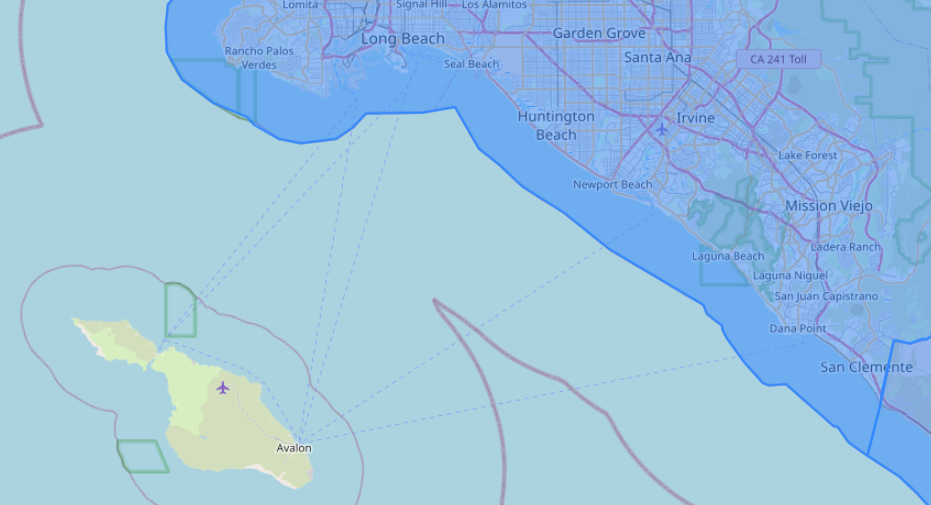

## merge `ntd_service` to `city_to_rtpa`
join on City. attach RTPA name to ntd annual data

In [49]:
display(
    ntd_service.info(), # annual NTD data #421 reporters
    city_to_rtpa.columns #city to rtpa crosswalk # 1523 CDPs w/ RTPA names
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         421 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

None

Index(['FID', 'cdp_name', 'name_lsad', 'geometry', 'index_right', 'RTPA',
       'LABEL_RTPA'],
      dtype='object')

In [51]:
ntd_data_to_rtpa = ntd_service.merge(
    city_to_rtpa[["cdp_name","RTPA"]],
    left_on=("city"),
    right_on=("cdp_name"),
    how="left", # with left join, got some unmerged rows. aka reporters that dont appear in the city_to_rtpa list (CDP?)
    indicator=True
)
ntd_data_to_rtpa.info() #424 rows 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 423
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  424 non-null    int64   
 1   ntd_id                                       424 non-null    object  
 2   agency                                       424 non-null    object  
 3   reporter_type                                424 non-null    object  
 4   organization_type                            424 non-null    object  
 5   city                                         424 non-null    object  
 6   state                                        424 non-null    object  
 7   primary_uza_name                             331 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  424 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  424 non-null    floa

In [55]:
ntd_data_to_rtpa["agency"].value_counts().head(10)

Los Angeles County                                10
City of Burbank                                    4
Palos Verdes Peninsula Transit Authority           3
Eastern Sierra Transit Authority                   2
City of Huntington Park                            2
San Bernardino County Transportation Authority     2
Stanislaus Regional Transit Authority              2
Tulare County Regional Transit Agency              2
City of Pasadena, dba: Pasadena Transit            2
Pomona Valley Transportation Authority             2
Name: agency, dtype: int64

In [53]:
ntd_data_to_rtpa[ntd_data_to_rtpa["ntd_id"]=="90256"]

,report_year,ntd_id,agency,reporter_type,organization_type,city,state,primary_uza_name,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,cdp_name,RTPA,_merge
320,2023,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",28827.0,271752.0,171517.0,Burbank,Metropolitan Transportation Commission,both
321,2023,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",28827.0,271752.0,171517.0,Burbank,Southern California Association of Governments,both
322,2022,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",27008.0,243964.0,161971.0,Burbank,Metropolitan Transportation Commission,both
323,2022,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",27008.0,243964.0,161971.0,Burbank,Southern California Association of Governments,both


In [57]:
ntd_data_to_rtpa["_merge"].value_counts() # 9 left_only rows, who are there?



both          415
left_only       9
right_only      0
Name: _merge, dtype: int64



then Update `ntd_data_to_rtpa` with the following information:
- 90079 SunLine Transit > COUNTY = Riverside County. RTPA = Southern California Association of Governments
- 90229 El Dorado County Transit Authority > COUNTY = El Dorado County. RTPA =  El Dorado County Transportation Commission
- 90287 Palos Verdes Peninsula Transit Authority > COUNTY = Los Angeles County. RTPA = Southern California Association of Governments
- 91092 Tahoe Transportation District > COUNTY El Dorado County. RTPA = Tahoe Regional Planning Agency

In [ ]:
ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"][["report_year","agency","city"]]
    
# most of these are sub/regions in CA, not actual cities or CDP. will need a manual edit



In [ ]:
# checking CDP names in cities lsit
city_check_list = list(ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"]["city"].unique())

pattern = "|".join(city_check_list)

display(
    city_check_list,
    city_to_rtpa[city_to_rtpa["cdp_name"].str.contains(pattern, case=False)],
    cdp_map[cdp_map["cdp_name"].str.contains(pattern, case=False)],
    #cdp_map[cdp_map["cdp_name"].str.contains("fork")]
)



## manual updates to `ntd_data_to_rtpa`
